In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os
import numpy as np
import matplotlib.ticker as ticker
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Load the dataset
df = pd.read_csv('Kaggle Superstore.csv', encoding='latin-1')

In [3]:
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [4]:
df['Product Name'].nunique()

1850

In [5]:
df['Product ID'].nunique()

1862

### A product name has multiple product IDs

In [6]:
# Check if any product name still maps to multiple product IDs
validation_product_name_counts = df.groupby("Product Name")["Product ID"].nunique()

# Find product names that still have multiple product IDs
invalid_entries = validation_product_name_counts[validation_product_name_counts > 1]

# Display the result grouped by product name along with count of product IDs
if invalid_entries.empty:
    print("Validation passed: No product name has multiple product IDs.")
else:
    print("Validation failed: Some product names still have multiple product IDs.")
    for product_name in invalid_entries.index:
        product_ids = df[df["Product Name"] == product_name]["Product ID"].unique()
        num_product_ids = len(product_ids)
        print(f"Product Name: {product_name}")
        print(f"Associated Product IDs ({num_product_ids}): {list(product_ids)}")
        print("-" * 50)

Validation failed: Some product names still have multiple product IDs.
Product Name: #10- 4 1/8" x 9 1/2" Recycled Envelopes
Associated Product IDs (2): ['OFF-EN-10000461', 'OFF-EN-10000781']
--------------------------------------------------
Product Name: Avery Non-Stick Binders
Associated Product IDs (2): ['OFF-BI-10004140', 'OFF-BI-10000829']
--------------------------------------------------
Product Name: Easy-staple paper
Associated Product IDs (8): ['OFF-PA-10000249', 'OFF-PA-10000474', 'OFF-PA-10000349', 'OFF-PA-10003127', 'OFF-PA-10001685', 'OFF-PA-10004947', 'OFF-PA-10000565', 'OFF-PA-10002764']
--------------------------------------------------
Product Name: Eldon Wave Desk Accessories
Associated Product IDs (2): ['FUR-FU-10000023', 'FUR-FU-10003981']
--------------------------------------------------
Product Name: KI Adjustable-Height Table
Associated Product IDs (2): ['FUR-TA-10004086', 'FUR-TA-10001039']
--------------------------------------------------
Product Name: Okid

In [7]:
# Creating a mapping of product names to unique product IDs
product_name_to_ids = df.groupby("Product Name")["Product ID"].unique()

# Creating a mapping of product IDs to unique product names
product_id_to_names = df.groupby("Product ID")["Product Name"].unique()

# Dictionary to store the final mapping of product names to a single product ID
final_product_id_mapping = {}

# Iterate through each product name that has multiple product IDs
for product_name, product_ids in product_name_to_ids.items():
    # Find a product ID that is only associated with this product name
    valid_product_id = None
    for product_id in product_ids:
        if len(product_id_to_names[product_id]) == 1:  # Ensure it's unique to this product name
            valid_product_id = product_id
            break
    
    # If we found a valid product ID, store it in the mapping
    if valid_product_id:
        final_product_id_mapping[product_name] = valid_product_id

# Replace all product IDs for a given product name with the selected unique product ID
df["Product ID"] = df["Product Name"].map(final_product_id_mapping).fillna(df["Product ID"])

# Display the updated dataframe
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [8]:
# Check if any product name still maps to multiple product IDs
validation_product_name_counts = df.groupby("Product Name")["Product ID"].nunique()

# Find product names that still have multiple product IDs
invalid_entries = validation_product_name_counts[validation_product_name_counts > 1]

# Display the result
if invalid_entries.empty:
    print("Validation passed: No product name has multiple product IDs.")
else:
    print("Validation failed: Some product names still have multiple product IDs.")
    tools.display_dataframe_to_user(name="Products with multiple IDs after unification", dataframe=df[df["Product Name"].isin(invalid_entries.index)][["Product Name", "Product ID"]].drop_duplicates())


Validation passed: No product name has multiple product IDs.


### A product ID maps to multiple product names

In [9]:
# Check if any product ID still maps to multiple product names
validation_product_id_counts = df.groupby("Product ID")["Product Name"].nunique()

# Find product IDs that still have multiple product names
invalid_entries = validation_product_id_counts[validation_product_id_counts > 1]

# Display the result grouped by product ID along with the count of product names
if invalid_entries.empty:
    print("Validation passed: No product ID refers to multiple product names.")
else:
    print("Validation failed: Some product IDs still refer to multiple product names.")
    for product_id in invalid_entries.index:
        product_names = df[df["Product ID"] == product_id]["Product Name"].unique()
        num_product_names = len(product_names)
        print(f"Product ID: {product_id}")
        print(f"Associated Product Names ({num_product_names}): {list(product_names)}")
        print("-" * 50)

Validation failed: Some product IDs still refer to multiple product names.
Product ID: FUR-BO-10002213
Associated Product Names (2): ['DMI Eclipse Executive Suite Bookcases', 'Sauder Forest Hills Library, Woodland Oak Finish']
--------------------------------------------------
Product ID: FUR-CH-10001146
Associated Product Names (2): ["Global Value Mid-Back Manager's Chair, Gray", 'Global Task Chair, Black']
--------------------------------------------------
Product ID: FUR-FU-10001473
Associated Product Names (2): ['DAX Wood Document Frame', 'Eldon Executive Woodline II Desk Accessories, Mahogany']
--------------------------------------------------
Product ID: FUR-FU-10004017
Associated Product Names (2): ['Tenex Contemporary Contur Chairmats for Low and Medium Pile Carpet, Computer, 39" x 49"', 'Executive Impressions 13" Chairman Wall Clock']
--------------------------------------------------
Product ID: FUR-FU-10004091
Associated Product Names (2): ['Howard Miller 13" Diameter Goldt

In [10]:
# Identifying product IDs that are associated with multiple product names
product_id_to_names = df.groupby("Product ID")["Product Name"].unique()

# Dictionary to store the final mapping of product IDs to a single product name
final_product_name_mapping = {}

# List to track newly generated unique product IDs
existing_product_ids = set(df["Product ID"].unique())

# Function to generate a unique product ID
def generate_unique_product_id(existing_ids, base_id):
    counter = 1
    new_id = base_id + f"-{counter}"
    while new_id in existing_ids:
        counter += 1
        new_id = base_id + f"-{counter}"
    existing_ids.add(new_id)
    return new_id

# Iterate through each product ID that has multiple product names
for product_id, product_names in product_id_to_names.items():
    # Select one product name to keep the original product ID
    main_product_name = product_names[0]
    final_product_name_mapping[main_product_name] = product_id

    # Assign new unique product IDs to the other product names
    for product_name in product_names[1:]:
        base_id = product_id[:-2] if "-" in product_id else product_id  # Keeping the format similar
        new_product_id = generate_unique_product_id(existing_product_ids, base_id)
        final_product_name_mapping[product_name] = new_product_id

# Replace all product names for a given product ID with the selected or generated unique product ID
df["Product ID"] = df["Product Name"].map(final_product_name_mapping).fillna(df["Product ID"])

# Display the updated dataframe
df

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028
9990,9991,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332
9991,9992,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932
9992,9993,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200


In [11]:
# Check if any product ID still maps to multiple product names
validation_product_id_counts = df.groupby("Product ID")["Product Name"].nunique()

# Find product IDs that still have multiple product names
invalid_entries = validation_product_id_counts[validation_product_id_counts > 1]

# Display the result grouped by product ID along with the count of product names
if invalid_entries.empty:
    print("Validation passed: No product ID refers to multiple product names.")
else:
    print("Validation failed: Some product IDs still refer to multiple product names.")
    for product_id in invalid_entries.index:
        product_names = df[df["Product ID"] == product_id]["Product Name"].unique()
        num_product_names = len(product_names)
        print(f"Product ID: {product_id}")
        print(f"Associated Product Names ({num_product_names}): {list(product_names)}")
        print("-" * 50)

Validation passed: No product ID refers to multiple product names.


### Duplicate rows based on "Order ID" and "Product ID"

In [12]:
# Check for duplicate rows based on "Order ID" and "Product ID"
duplicate_rows = df[df.duplicated(subset=["Order ID", "Product ID"], keep=False)]

# Display the duplicate rows
duplicate_rows

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
350,351,CA-2016-129714,9/1/2016,9/3/2016,First Class,AB-10060,Adam Bellavance,Home Office,United States,New York City,...,10009,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,24.560,2,0.0,11.5432
352,353,CA-2016-129714,9/1/2016,9/3/2016,First Class,AB-10060,Adam Bellavance,Home Office,United States,New York City,...,10009,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,49.120,4,0.0,23.0864
430,431,US-2016-123750,4/15/2016,4/21/2016,Standard Class,RB-19795,Ross Baird,Home Office,United States,Gastonia,...,28052,South,TEC-AC-10004659,Technology,Accessories,Imation Secure+ Hardware Encrypted USB 2.0 Fla...,408.744,7,0.2,76.6395
431,432,US-2016-123750,4/15/2016,4/21/2016,Standard Class,RB-19795,Ross Baird,Home Office,United States,Gastonia,...,28052,South,TEC-AC-10004659,Technology,Accessories,Imation Secure+ Hardware Encrypted USB 2.0 Fla...,291.960,5,0.2,54.7425
1300,1301,CA-2016-137043,12/23/2016,12/25/2016,Second Class,LC-17140,Logan Currie,Consumer,United States,Springfield,...,22153,South,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",572.760,6,0.0,166.1004
1301,1302,CA-2016-137043,12/23/2016,12/25/2016,Second Class,LC-17140,Logan Currie,Consumer,United States,Springfield,...,22153,South,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",286.380,3,0.0,83.0502
3183,3184,CA-2017-152912,11/9/2017,11/12/2017,Second Class,BM-11650,Brian Moss,Corporate,United States,Columbia,...,21044,East,OFF-ST-10003208,Office Supplies,Storage,Adjustable Depth Letter/Legal Cart,1633.140,9,0.0,473.6106
3184,3185,CA-2017-152912,11/9/2017,11/12/2017,Second Class,BM-11650,Brian Moss,Corporate,United States,Columbia,...,21044,East,OFF-ST-10003208,Office Supplies,Storage,Adjustable Depth Letter/Legal Cart,544.380,3,0.0,157.8702
3405,3406,US-2014-150119,4/23/2014,4/27/2014,Standard Class,LB-16795,Laurel Beltran,Home Office,United States,Columbus,...,43229,East,FUR-CH-10002965,Furniture,Chairs,Global Leather Highback Executive Chair with P...,281.372,2,0.3,-12.0588
3406,3407,US-2014-150119,4/23/2014,4/27/2014,Standard Class,LB-16795,Laurel Beltran,Home Office,United States,Columbus,...,43229,East,FUR-CH-10002965,Furniture,Chairs,Global Leather Highback Executive Chair with P...,281.372,2,0.3,-12.0588


In [13]:
# Aggregate duplicates by summing "Quantity," "Sales," and "Profit"
cleaned_df = df.groupby(["Order ID", "Product ID"], as_index=False).agg({
    "Row ID": "first",
    "Order Date": "first",
    "Ship Date": "first",
    "Ship Mode": "first",
    "Customer ID": "first",
    "Customer Name": "first",
    "Segment": "first",
    "Country": "first",
    "City": "first",
    "Postal Code": "first",
    "Region": "first",
    "Category": "first",
    "Sub-Category": "first",
    "Product Name": "first",
    "Discount": "first",
    "Quantity": "sum",
    "Sales": "sum",
    "Profit": "sum"
})

# Display the cleaned data
cleaned_df

,Order ID,Product ID,Row ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,Postal Code,Region,Category,Sub-Category,Product Name,Discount,Quantity,Sales,Profit
0,CA-2014-100006,TEC-PH-10002075,2718,9/7/2014,9/13/2014,Standard Class,DK-13375,Dennis Kane,Consumer,United States,New York City,10024,East,Technology,Phones,AT&T EL51110 DECT,0.0,3,377.970,109.6113
1,CA-2014-100090,FUR-TA-10003715,6288,7/8/2014,7/12/2014,Standard Class,EB-13705,Ed Braxton,Corporate,United States,San Francisco,94122,West,Furniture,Tables,Hon 2111 Invitation Series Corner Table,0.2,3,502.488,-87.9354
2,CA-2014-100090,OFF-BI-10001597,6289,7/8/2014,7/12/2014,Standard Class,EB-13705,Ed Braxton,Corporate,United States,San Francisco,94122,West,Office Supplies,Binders,"Wilson Jones Ledger-Size, Piano-Hinge Binder, ...",0.2,6,196.704,68.8464
3,CA-2014-100293,OFF-PA-10000176,9515,3/14/2014,3/18/2014,Standard Class,NF-18475,Neil Französisch,Home Office,United States,Jacksonville,32216,South,Office Supplies,Paper,Xerox 1887,0.2,6,91.056,31.8696
4,CA-2014-100328,OFF-BI-10000343,3084,1/28/2014,2/3/2014,Standard Class,JC-15340,Jasper Cacioppo,Consumer,United States,New York City,10024,East,Office Supplies,Binders,"Pressboard Covers with Storage Hooks, 9 1/2"" x...",0.2,1,3.928,1.3257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9981,US-2017-169551,OFF-PA-10004100,5931,7/7/2017,7/9/2017,First Class,RL-19615,Rob Lucas,Consumer,United States,Philadelphia,19120,East,Office Supplies,Paper,Xerox 216,0.2,3,15.552,5.4432
9982,US-2017-169551,OFF-ST-10004835,5933,7/7/2017,7/9/2017,First Class,RL-19615,Rob Lucas,Consumer,United States,Philadelphia,19120,East,Office Supplies,Storage,Plastic Stacking Crates & Casters,0.2,3,13.392,1.0044
9983,US-2017-169551,TEC-AC-10002018,5934,7/7/2017,7/9/2017,First Class,RL-19615,Rob Lucas,Consumer,United States,Philadelphia,19120,East,Technology,Accessories,AmazonBasics 3-Button USB Wired Mouse,0.2,3,16.776,4.8231
9984,US-2017-169551,TEC-AC-10003033,5935,7/7/2017,7/9/2017,First Class,RL-19615,Rob Lucas,Consumer,United States,Philadelphia,19120,East,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,0.2,2,527.920,85.7870


In [80]:
# Identify duplicate rows again based on "Order ID" and "Product ID"
duplicate_rows = df[df.duplicated(subset=["Order ID", "Product ID"], keep=False)]

# Aggregate only the duplicated rows
aggregated_duplicates = duplicate_rows.groupby(["Order ID", "Product ID"], as_index=False).agg({
    "Quantity": "sum",
    "Sales": "sum",
    "Profit": "sum"
})
aggregated_duplicates

,Order ID,Product ID,Quantity,Sales,Profit
0,CA-2015-103135,OFF-BI-10000069,15,225.150,103.5690
1,CA-2016-129714,OFF-PA-10001970,6,73.680,34.6296
2,CA-2016-137043,FUR-FU-10003664,9,859.140,249.1506
3,CA-2016-140571,OFF-PA-10001954,16,365.440,168.1024
4,CA-2017-118017,TEC-AC-10002006,14,179.088,24.6246
5,CA-2017-152912,OFF-ST-10003208,12,2177.520,631.4808
6,US-2014-150119,FUR-CH-10002965,4,562.744,-24.1176
7,US-2016-123750,TEC-AC-10004659,12,700.704,131.3820


In [14]:
# Count the number of duplicate occurrences for each 'Order ID' and 'Product ID'
duplicate_counts = cleaned_df.duplicated(subset=['Order ID', 'Product ID'], keep=False).sum()

# Display the count of duplicate rows
duplicate_counts

0

In [15]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "Cleaned_Row_Data.csv")

# Save the cleaned dataset
df.to_csv(file_path, index=False)

print(f"Cleaned Row Data saved successfully at: {file_path}")

Cleaned Row Data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project\Cleaned_Row_Data.csv


In [16]:
# Extract Customers table
customers_df = df[['Customer ID', 'Customer Name', 'Segment']].drop_duplicates()

# Extract Products table
products_df = df[['Product ID', 'Product Name', 'Category', 'Sub-Category']].drop_duplicates()

# Extract Orders table with foreign keys
orders_df = df[['Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Country', 'City', 'State', 'Region']].drop_duplicates()

# Extract Order details table
order_details_df = df[['Order ID', 'Product ID', 'Sales', 'Quantity', 'Discount', 'Profit']].drop_duplicates()

In [17]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "customers.csv")

# Save the cleaned dataset
customers_df.to_csv(file_path, index=False)

print(f"Customers data saved successfully at: {file_path}")

Customers data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data\customers.csv


In [18]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "products.csv")

# Save the cleaned dataset
products_df.to_csv(file_path, index=False)

print(f"Products data saved successfully at: {file_path}")

Products data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data\products.csv


In [19]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "orders.csv")

# Save the cleaned dataset
orders_df.to_csv(file_path, index=False)

print(f"Orders data saved successfully at: {file_path}")

Orders data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data\orders.csv


In [20]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "order_details.csv")

# Save the cleaned dataset
order_details_df.to_csv(file_path, index=False)

print(f"Order Details data saved successfully at: {file_path}")

Order Details data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Normalized Data\order_details.csv


# Customer Table

In [21]:
customers_df

,Customer ID,Customer Name,Segment
0,CG-12520,Claire Gute,Consumer
2,DV-13045,Darrin Van Huff,Corporate
3,SO-20335,Sean O'Donnell,Consumer
5,BH-11710,Brosina Hoffman,Consumer
12,AA-10480,Andrew Allen,Consumer
...,...,...,...
8666,CJ-11875,Carl Jackson,Corporate
9209,RS-19870,Roy Skaria,Home Office
9399,SC-20845,Sung Chung,Consumer
9441,RE-19405,Ricardo Emerson,Consumer


In [22]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 9558
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Customer ID    793 non-null    object
 1   Customer Name  793 non-null    object
 2   Segment        793 non-null    object
dtypes: object(3)
memory usage: 24.8+ KB


In [23]:
customers_df.describe()

,Customer ID,Customer Name,Segment
count,793,793,793
unique,793,793,3
top,CG-12520,Claire Gute,Consumer
freq,1,1,409


In [24]:
# Check for duplicates and drop if any
print("Duplicate rows:", customers_df.duplicated().sum())

Duplicate rows: 0


In [25]:
# Trim whitespace in text columns
customers_df_cleaned = customers_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [26]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "customers_cleaned.csv")

# Save the cleaned dataset
customers_df_cleaned.to_csv(file_path, index=False)

print(f"Cleaned data saved successfully at: {file_path}")

Cleaned data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data\customers_cleaned.csv


# Products Table

In [27]:
products_df

,Product ID,Product Name,Category,Sub-Category
0,FUR-BO-10001798,Bush Somerset Collection Bookcase,Furniture,Bookcases
1,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs
2,OFF-LA-10000240,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels
3,FUR-TA-10000577,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables
4,OFF-ST-10000760,Eldon Fold 'N Roll Cart System,Office Supplies,Storage
...,...,...,...,...
9521,TEC-PH-10002817,RCA ViSYS 25425RE1 Corded phone,Technology,Phones
9562,TEC-MA-10003589,Cisco 8961 IP Phone Charcoal,Technology,Machines
9604,OFF-AP-10003099,"Eureka Hand Vacuum, Bagless",Office Supplies,Appliances
9673,TEC-PH-10002645,LG G2,Technology,Phones


In [28]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1850 entries, 0 to 9935
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Product ID    1850 non-null   object
 1   Product Name  1850 non-null   object
 2   Category      1850 non-null   object
 3   Sub-Category  1850 non-null   object
dtypes: object(4)
memory usage: 72.3+ KB


In [29]:
products_df.describe()

,Product ID,Product Name,Category,Sub-Category
count,1850,1850,1850,1850
unique,1850,1850,3,17
top,FUR-BO-10001798,Bush Somerset Collection Bookcase,Office Supplies,Paper
freq,1,1,1058,277


In [30]:
# Check for duplicates and drop if any
print("Duplicate rows:", products_df.duplicated().sum())

Duplicate rows: 0


In [31]:
# Trim whitespace in text columns
products_df_cleaned = products_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [32]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "products_cleaned.csv")

# Save the cleaned dataset
products_df_cleaned.to_csv(file_path, index=False)

print(f"Cleaned data saved successfully at: {file_path}")

Cleaned data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data\products_cleaned.csv


# Orders Table

In [33]:
orders_df

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country,City,State,Region
0,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,United States,Henderson,Kentucky,South
2,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,United States,Los Angeles,California,West
3,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,South
5,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,United States,Los Angeles,California,West
12,CA-2017-114412,4/15/2017,4/20/2017,Standard Class,AA-10480,United States,Concord,North Carolina,South
...,...,...,...,...,...,...,...,...,...
9986,CA-2016-125794,9/29/2016,10/3/2016,Standard Class,ML-17410,United States,Los Angeles,California,West
9987,CA-2017-163629,11/17/2017,11/21/2017,Standard Class,RA-19885,United States,Athens,Georgia,South
9989,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,United States,Miami,Florida,South
9990,CA-2017-121258,2/26/2017,3/3/2017,Standard Class,DB-13060,United States,Costa Mesa,California,West


In [34]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5009 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Order ID     5009 non-null   object
 1   Order Date   5009 non-null   object
 2   Ship Date    5009 non-null   object
 3   Ship Mode    5009 non-null   object
 4   Customer ID  5009 non-null   object
 5   Country      5009 non-null   object
 6   City         5009 non-null   object
 7   State        5009 non-null   object
 8   Region       5009 non-null   object
dtypes: object(9)
memory usage: 391.3+ KB


In [35]:
orders_df.describe()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country,City,State,Region
count,5009,5009,5009,5009,5009,5009,5009,5009,5009
unique,5009,1237,1334,4,793,1,531,49,4
top,CA-2016-152156,9/5/2016,11/16/2017,Standard Class,EP-13915,United States,New York City,California,West
freq,1,19,17,2994,17,5009,450,1021,1611


In [36]:
# Convert dates to datetime format
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], errors='coerce')
orders_df['Ship Date'] = pd.to_datetime(orders_df['Ship Date'], errors='coerce')

In [37]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5009 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Order ID     5009 non-null   object        
 1   Order Date   5009 non-null   datetime64[ns]
 2   Ship Date    5009 non-null   datetime64[ns]
 3   Ship Mode    5009 non-null   object        
 4   Customer ID  5009 non-null   object        
 5   Country      5009 non-null   object        
 6   City         5009 non-null   object        
 7   State        5009 non-null   object        
 8   Region       5009 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 391.3+ KB


In [38]:
# Check for duplicates and drop if any
print("Duplicate rows:", orders_df.duplicated().sum())

Duplicate rows: 0


In [39]:
# Trim whitespace in text columns
orders_df_cleaned = orders_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [40]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "orders_cleaned.csv")

# Save the cleaned dataset
orders_df_cleaned.to_csv(file_path, index=False)

print(f"Cleaned data saved successfully at: {file_path}")

Cleaned data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data\orders_cleaned.csv


# Order Details Table

In [81]:
order_details_df

,Order ID,Product ID,Sales,Quantity,Discount,Profit
0,CA-2016-152156,FUR-BO-10001798,261.9600,2,0.00,41.9136
1,CA-2016-152156,FUR-CH-10000454,731.9400,3,0.00,219.5820
2,CA-2016-138688,OFF-LA-10000240,14.6200,2,0.00,6.8714
3,US-2015-108966,FUR-TA-10000577,957.5775,5,0.45,-383.0310
4,US-2015-108966,OFF-ST-10000760,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...
9981,CA-2016-137043,FUR-FU-10003664,859.1400,9,0.00,249.1506
9982,CA-2016-140571,OFF-PA-10001954,365.4400,16,0.00,168.1024
9983,CA-2017-118017,TEC-AC-10002006,179.0880,14,0.20,24.6246
9984,CA-2017-152912,OFF-ST-10003208,2177.5200,12,0.00,631.4808


In [42]:
# Count the number of duplicate occurrences for each 'Order ID' and 'Product ID'
duplicate_counts = order_details_df.duplicated(subset=['Order ID', 'Product ID'], keep=False).sum()

# Display the count of duplicate rows
duplicate_counts

14

In [43]:
# Check for duplicates based on the composite key (Order ID and Product ID)
duplicate_rows = order_details_df[order_details_df.duplicated(subset=['Order ID', 'Product ID'], keep=False)]

# Display the duplicate rows if any
duplicate_rows

,Order ID,Product ID,Sales,Quantity,Discount,Profit
350,CA-2016-129714,OFF-PA-10001970,24.560,2,0.0,11.5432
352,CA-2016-129714,OFF-PA-10001970,49.120,4,0.0,23.0864
430,US-2016-123750,TEC-AC-10004659,408.744,7,0.2,76.6395
431,US-2016-123750,TEC-AC-10004659,291.960,5,0.2,54.7425
1300,CA-2016-137043,FUR-FU-10003664,572.760,6,0.0,166.1004
1301,CA-2016-137043,FUR-FU-10003664,286.380,3,0.0,83.0502
3183,CA-2017-152912,OFF-ST-10003208,1633.140,9,0.0,473.6106
3184,CA-2017-152912,OFF-ST-10003208,544.380,3,0.0,157.8702
6498,CA-2015-103135,OFF-BI-10000069,135.090,9,0.0,62.1414
6500,CA-2015-103135,OFF-BI-10000069,90.060,6,0.0,41.4276


In [44]:
# Sum the 'Quantity', 'Sales', and 'Profit' for each duplicated 'Order ID' and 'Product ID'
aggregated_data = duplicate_rows.groupby(['Order ID', 'Product ID'], as_index=False).agg({
    'Quantity': 'sum',
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'first'  # Keeping the first discount value (assuming it's the same for duplicates)
})

# Remove the original duplicate rows from the main dataset
order_details_df = order_details_df.drop_duplicates(subset=['Order ID', 'Product ID'], keep=False)

# Append the aggregated records back into the dataset
order_details_df = pd.concat([order_details_df, aggregated_data], ignore_index=True)

# Display the cleaned dataset
order_details_df

,Order ID,Product ID,Sales,Quantity,Discount,Profit
0,CA-2016-152156,FUR-BO-10001798,261.9600,2,0.00,41.9136
1,CA-2016-152156,FUR-CH-10000454,731.9400,3,0.00,219.5820
2,CA-2016-138688,OFF-LA-10000240,14.6200,2,0.00,6.8714
3,US-2015-108966,FUR-TA-10000577,957.5775,5,0.45,-383.0310
4,US-2015-108966,OFF-ST-10000760,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...
9981,CA-2016-137043,FUR-FU-10003664,859.1400,9,0.00,249.1506
9982,CA-2016-140571,OFF-PA-10001954,365.4400,16,0.00,168.1024
9983,CA-2017-118017,TEC-AC-10002006,179.0880,14,0.20,24.6246
9984,CA-2017-152912,OFF-ST-10003208,2177.5200,12,0.00,631.4808


In [45]:
# Count the number of duplicate occurrences for each 'Order ID' and 'Product ID'
duplicate_counts = order_details_df.duplicated(subset=['Order ID', 'Product ID'], keep=False).sum()

# Display the count of duplicate rows
duplicate_counts

0

In [46]:
orders_df['Order ID'].nunique()

5009

In [47]:
order_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9986 entries, 0 to 9985
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order ID    9986 non-null   object 
 1   Product ID  9986 non-null   object 
 2   Sales       9986 non-null   float64
 3   Quantity    9986 non-null   int64  
 4   Discount    9986 non-null   float64
 5   Profit      9986 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 468.2+ KB


In [48]:
order_details_df.describe()

,Sales,Quantity,Discount,Profit
count,9986.000000,9986.000000,9986.000000,9986.000000
mean,230.013968,3.792409,0.156258,28.681062
std,623.658843,2.233461,0.206499,234.394585
min,0.444000,1.000000,0.000000,-6599.978000
25%,17.248000,2.000000,0.000000,1.728000
50%,54.432000,3.000000,0.200000,8.641350
75%,209.937500,5.000000,0.200000,29.362500
max,22638.480000,16.000000,0.800000,8399.976000


In [49]:
# Check for duplicates and drop if any
print("Duplicate rows:", order_details_df.duplicated().sum())

Duplicate rows: 0


In [50]:
# Trim whitespace in text columns
order_details_df_cleaned = order_details_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [51]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df["Sales"].quantile(0.25)
Q3 = df["Sales"].quantile(0.75)

# Compute the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Extract the full records of outliers in the Sales column
outlier_records = df[(df["Sales"] < lower_bound) | (df["Sales"] > upper_bound)]
    
# Display the full records of the outliers
print("Full Records of Outlier Sales Data:")
outlier_records

Full Records of Outlier Sales Data:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152
10,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
11,12,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.4240,4,0.20,68.3568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9931,9932,CA-2015-104948,11/13/2015,11/17/2015,Standard Class,KH-16510,Keith Herrera,Consumer,United States,San Bernardino,...,92404,West,FUR-BO-10004357,Furniture,Bookcases,O'Sullivan Living Dimensions 3-Shelf Bookcases,683.3320,4,0.15,-40.1960
9942,9943,CA-2014-143371,12/28/2014,1/3/2015,Standard Class,MD-17350,Maribeth Dona,Consumer,United States,Anaheim,...,92804,West,OFF-ST-10001128,Office Supplies,Storage,"Carina Mini System Audio Rack, Model AR050B",998.8200,9,0.00,29.9646
9947,9948,CA-2017-121559,6/1/2017,6/3/2017,Second Class,HW-14935,Helen Wasserman,Corporate,United States,Indianapolis,...,46203,Central,FUR-CH-10003746,Furniture,Chairs,Hon 4070 Series Pagoda Round Back Stacking Chairs,1925.8800,6,0.00,539.2464
9948,9949,CA-2017-121559,6/1/2017,6/3/2017,Second Class,HW-14935,Helen Wasserman,Corporate,United States,Indianapolis,...,46203,Central,OFF-AP-10002945,Office Supplies,Appliances,Honeywell Enviracaire Portable HEPA Air Cleane...,2405.2000,8,0.00,793.7160


In [52]:
# # Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = df["Sales"].quantile(0.25)
# Q3 = df["Sales"].quantile(0.75)

# # Compute the IQR
# IQR = Q3 - Q1

# # Define the lower and upper bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter the dataframe to remove outliers
# df_cleaned = df[(df["Sales"] >= lower_bound) & (df["Sales"] <= upper_bound)]

# # Display the cleaned dataframe
# df_cleaned

# # Optionally, save the cleaned dataset
# # df_cleaned.to_csv("cleaned_data.csv", index=False)

In [53]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "outlier_records.csv")

# Save the cleaned dataset
outlier_records.to_csv(file_path, index=False)

print(f"Outlier Records data saved successfully at: {file_path}")

Outlier Records data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project\outlier_records.csv


In [54]:
# Define the folder path
folder_path = "E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data"

# Ensure the folder exists, create it if it doesn't
os.makedirs(folder_path, exist_ok=True)

# Define the full file path
file_path = os.path.join(folder_path, "order_details_df_cleaned.csv")

# Save the cleaned dataset
order_details_df_cleaned.to_csv(file_path, index=False)

print(f"Cleaned data saved successfully at: {file_path}")

Cleaned data saved successfully at: E:/DEPI/Final Project/Super Sales Store Depi Final Project/Cleaned Data\order_details_df_cleaned.csv


# Group Questions

# 1. Dataset Overview

A- Total number of orders

In [55]:
total_orders = orders_df_cleaned["Order ID"].nunique()
print ("Total Orders:", total_orders)

Total Orders: 5009


B- Total sales amount

In [56]:
total_sales = order_details_df_cleaned["Sales"].sum()
print ("Total Sales:", total_sales)

Total Sales: 2296919.4883


C- Total number of products sold

In [57]:
total_products_sold = order_details_df_cleaned["Quantity"].sum()
print ("Total Products Sold:", total_products_sold)

Total Products Sold: 37871


D- Number of categories and subcategories

In [58]:
num_categories = products_df_cleaned["Category"].nunique()
print ("Number of Categories:", num_categories)

num_subcategories = products_df_cleaned["Sub-Category"].nunique()
print ("Number of Subcategories:", num_subcategories)

Number of Categories: 3
Number of Subcategories: 17


# 2. Sales Analysis

A- Top-selling products in Sales and Quanity

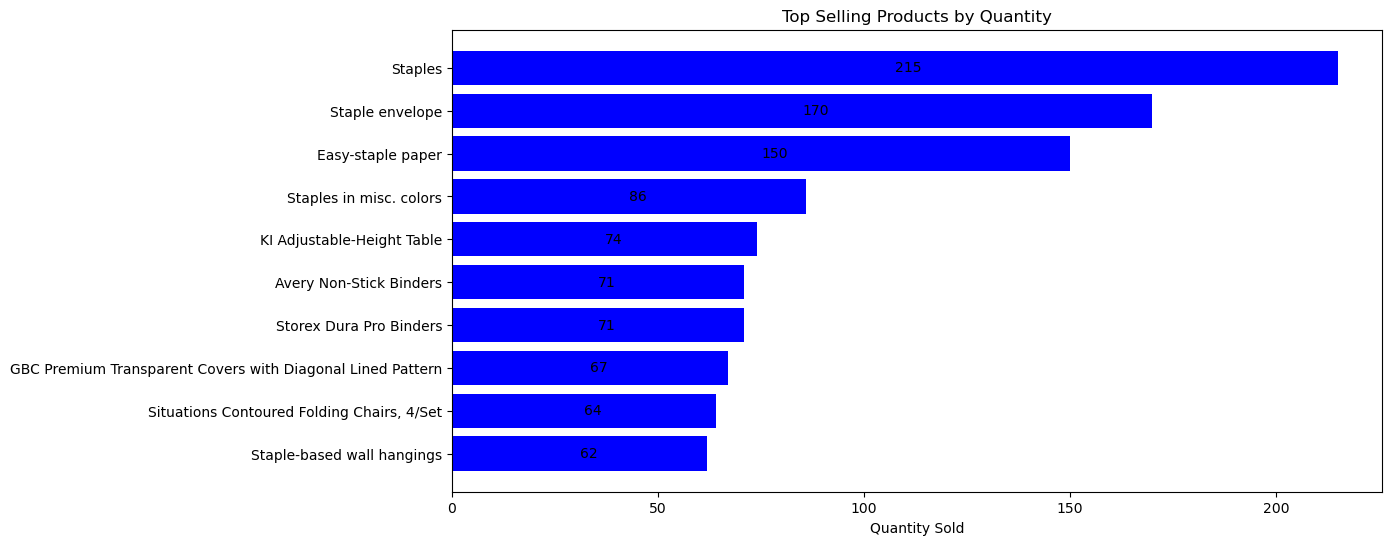

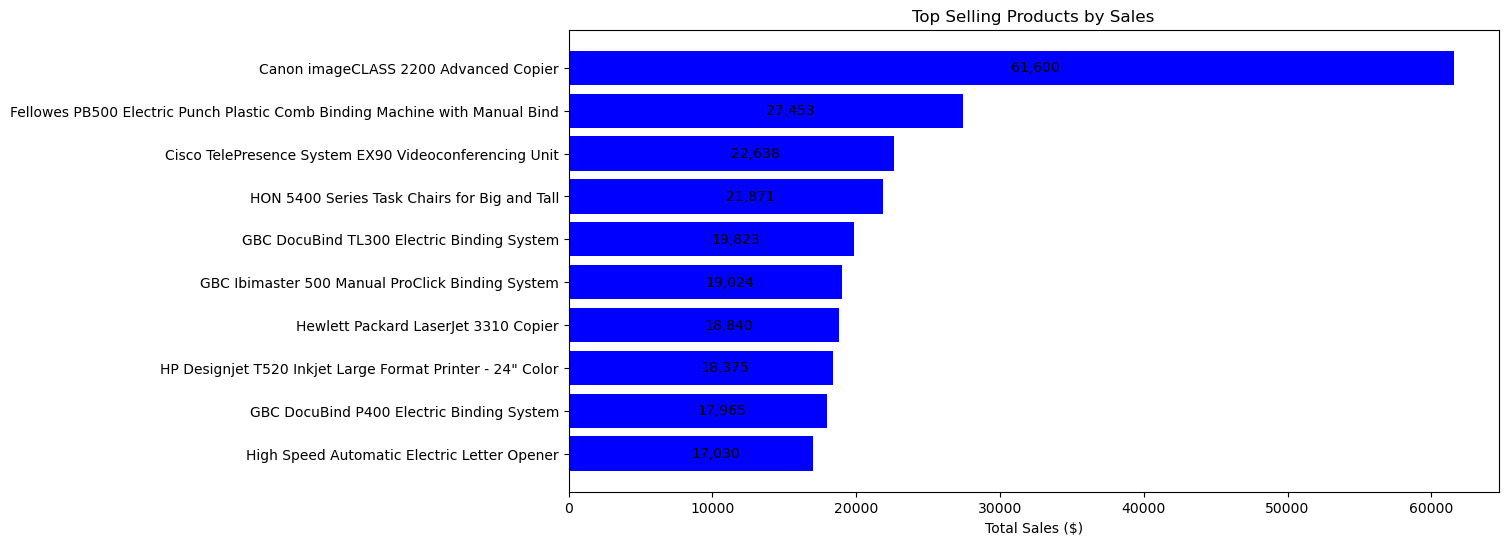

In [59]:
top_products = order_details_df_cleaned.groupby("Product ID")["Quantity"].sum().reset_index()
top_products = top_products.merge(products_df_cleaned, on="Product ID").sort_values(by="Quantity", ascending=False).head(10)

# Visualizing Top Selling Products
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_products["Product Name"], top_products["Quantity"], color='blue')
ax.set_xlabel("Quantity Sold")
ax.set_title("Top Selling Products by Quantity")

# Adding labels on bars
for bar in bars:
    ax.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}', ha='left', va='center', fontsize=10, color='black')

plt.gca().invert_yaxis()  # Invert y-axis for ranking order
plt.show()


# Compute top-selling products based on total sales revenue
top_sales_products = order_details_df_cleaned.groupby("Product ID")["Sales"].sum().reset_index()
top_sales_products = top_sales_products.merge(products_df, on="Product ID").sort_values(by="Sales", ascending=False).head(10)

# Visualizing Top-Selling Products by Sales with Improved Label Placement
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_sales_products["Product Name"], top_sales_products["Sales"], color='blue')
ax.set_xlabel("Total Sales ($)")
ax.set_title("Top Selling Products by Sales")

# Adding labels on bars
for bar in bars:
    ax.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}', ha='left', va='center', fontsize=10, color='black')



# Invert y-axis for ranking order
plt.gca().invert_yaxis()

plt.show()

B- Top 10 Least-Selling Products VS. Top 10 Best-Selling Products

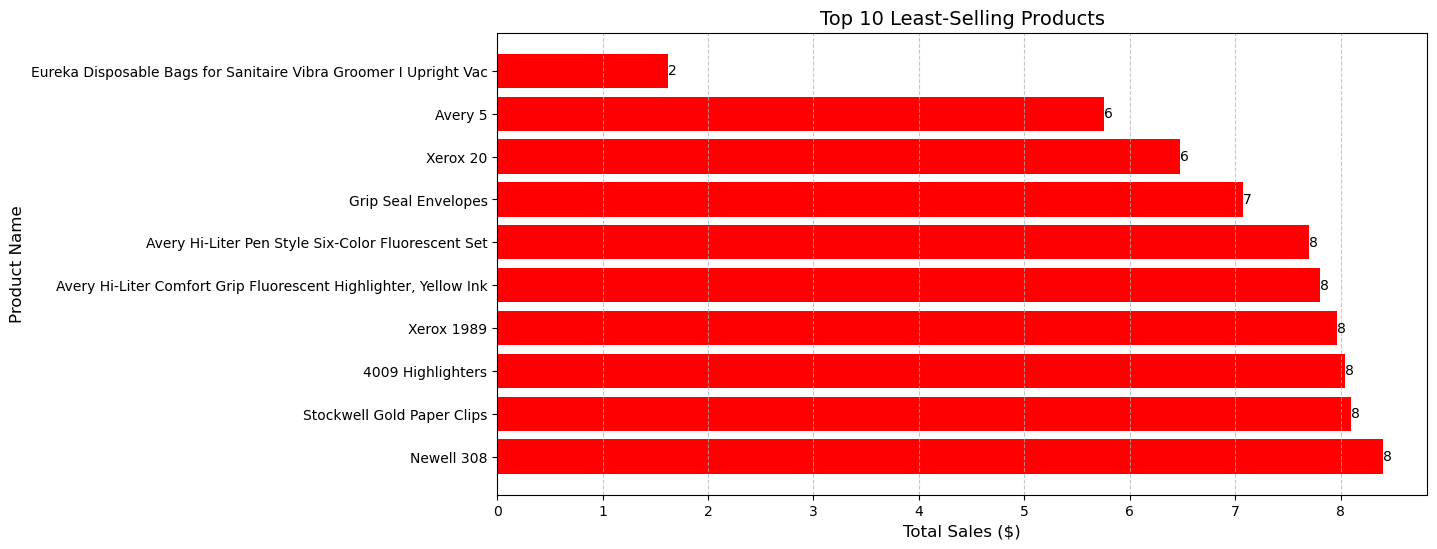

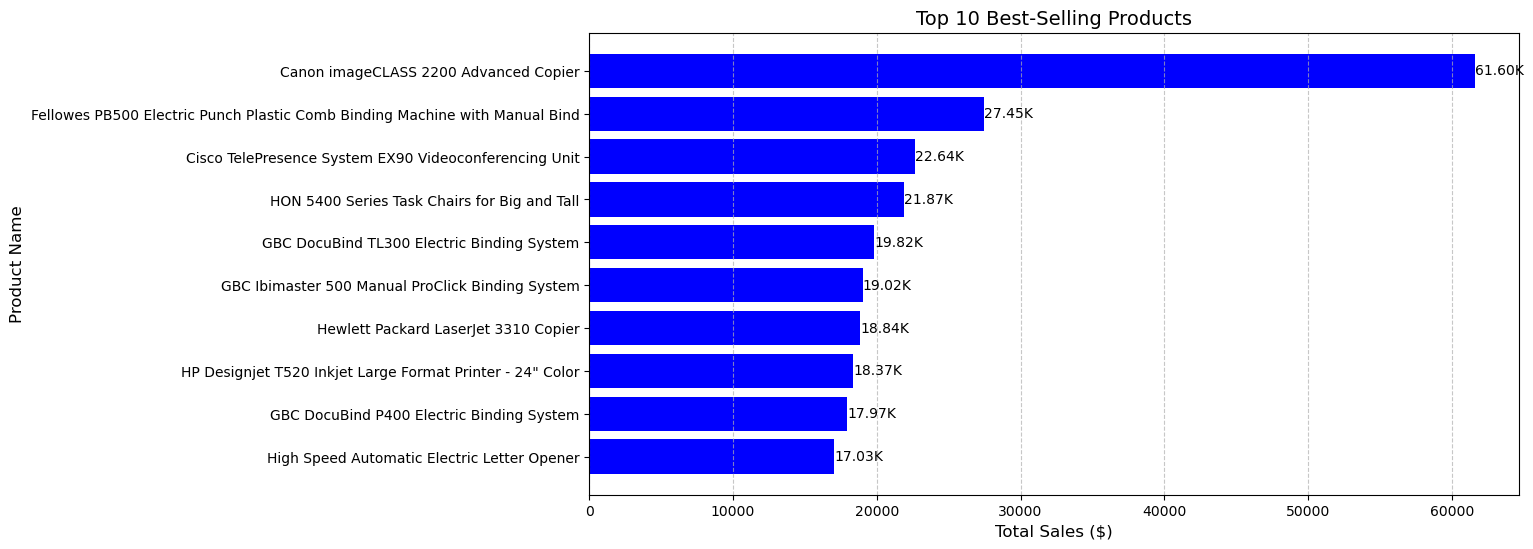

In [60]:
# Compute total sales for each product
product_sales = (
    order_details_df_cleaned
    .groupby("Product ID")["Sales"]
    .sum()
    .reset_index()
    .merge(products_df, on="Product ID", how="left")
    .sort_values(by="Sales", ascending=True)  # Sort in ascending order
)

# Get the top 10 least-selling products
least_selling_products = product_sales.head(10)

# Get the top 10 best-selling products
top_selling_products = product_sales.tail(10).sort_values(by="Sales", ascending=False)


# Plot Top 10 Least-Selling Products with normal number labels
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(least_selling_products["Product Name"], least_selling_products["Sales"], color="red")

# Add labels on bars in normal numbers
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,.0f}', 
            ha='left', va='center', fontsize=10, color='black')

# Formatting and labels
ax.set_xlabel("Total Sales ($)", fontsize=12)
ax.set_ylabel("Product Name", fontsize=12)
ax.set_title("Top 10 Least-Selling Products", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the lowest-selling product at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

# Plot Top 10 Best-Selling Products (remains in millions)
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_selling_products["Product Name"], top_selling_products["Sales"], color="blue")

# Add labels on bars in millions
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()/1_000:.2f}K', 
            ha='left', va='center', fontsize=10, color='black')

# Formatting and labels
ax.set_xlabel("Total Sales ($)", fontsize=12)
ax.set_ylabel("Product Name", fontsize=12)
ax.set_title("Top 10 Best-Selling Products", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the highest-selling product at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


C- Impact of Discount on Sales

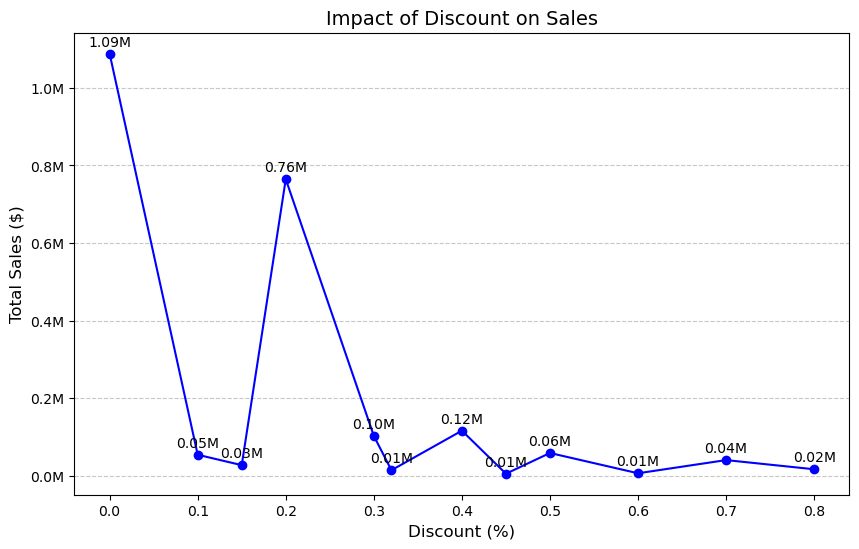

In [61]:
# Compute the impact of discount on sales
discount_sales = (
    order_details_df_cleaned
    .groupby("Discount")["Sales"]
    .sum()
    .reset_index()
    .sort_values(by="Discount")
)

# Plot the impact of discount on sales with y-axis in millions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(discount_sales["Discount"], discount_sales["Sales"], marker="o", linestyle="-", color="blue")

# Add labels on points in millions
for i, txt in enumerate(discount_sales["Sales"]):
    ax.text(discount_sales["Discount"][i], discount_sales["Sales"][i] + (total_sales * 0.005), f'{txt/1_000_000:.2f}M', 
            ha="center", va="bottom", fontsize=10, color='black')

# Formatting and labels
ax.set_xlabel("Discount (%)", fontsize=12)
ax.set_ylabel("Total Sales ($)", fontsize=12)
ax.set_title("Impact of Discount on Sales", fontsize=14)

# Format y-axis labels in millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


D- Impact of Order Quantity on Profit

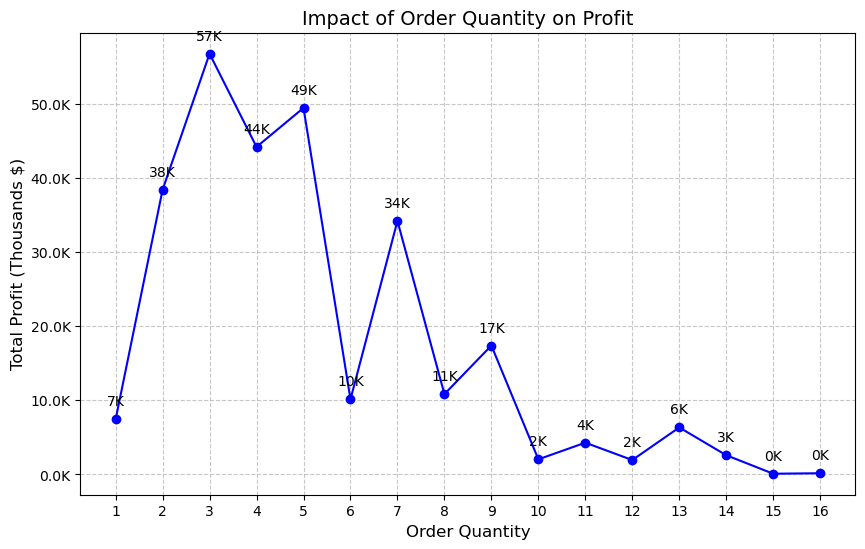

In [62]:
# Recalculate total profit
total_profit = order_details_df_cleaned["Profit"].sum()

# Compute the impact of order quantity on profit
quantity_profit = (
    order_details_df_cleaned
    .groupby("Quantity")["Profit"]
    .sum()
    .reset_index()
    .sort_values(by="Quantity")
)

#Plot the impact of order quantity on profit
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quantity_profit["Quantity"], quantity_profit["Profit"], marker="o", linestyle="-", color="blue")

# Add labels on points in thousands
for i, txt in enumerate(quantity_profit["Profit"]):
    ax.text(quantity_profit["Quantity"][i], quantity_profit["Profit"][i] + (total_profit * 0.005), 
            f'{txt/1_000:,.0f}K', ha="center", va="bottom", fontsize=10, color='black')

# Formatting and labels
ax.set_xlabel("Order Quantity", fontsize=12)
ax.set_ylabel("Total Profit (Thousands $)", fontsize=12)
ax.set_title("Impact of Order Quantity on Profit", fontsize=14)

# Format y-axis labels in thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1_000:,.1f}K"))

# Set x-axis to display every step of 1
ax.set_xticks(quantity_profit["Quantity"])

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


E- Number of Orders and Sales in Each Category

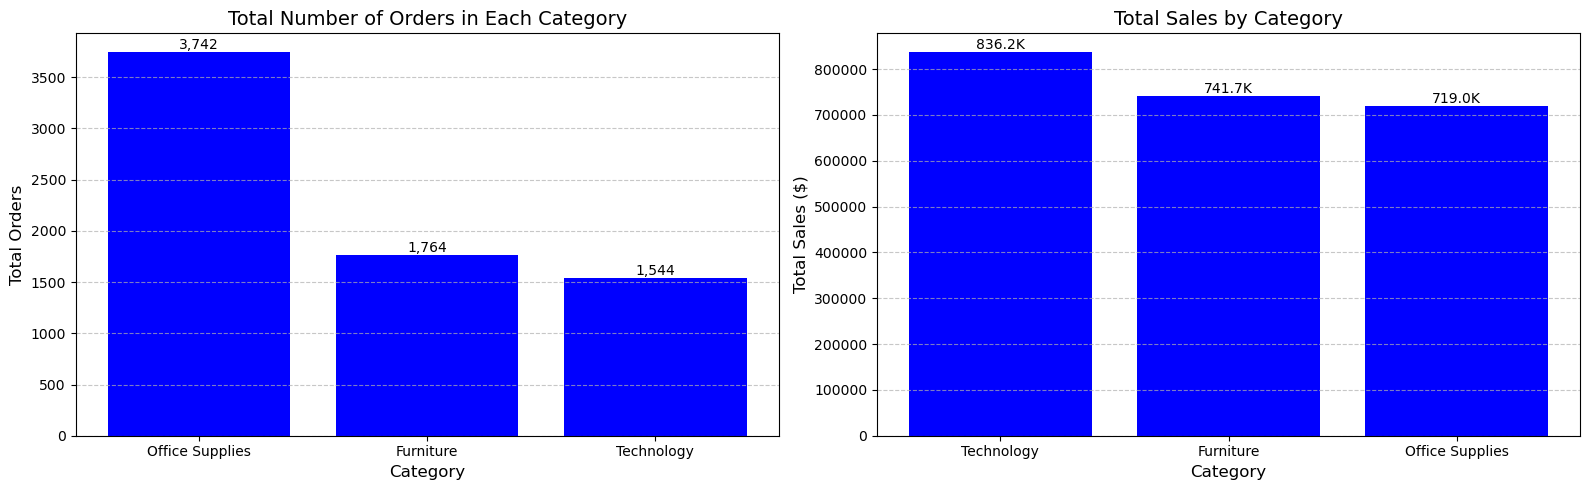

In [63]:
# Compute total number of orders for each category
category_orders = (
    order_details_df_cleaned
    .merge(products_df, on="Product ID", how="left")
    .groupby("Category")["Order ID"]
    .nunique()
    .reset_index()
    .sort_values(by="Order ID", ascending=False)
    .rename(columns={"Order ID": "Total Orders"})
)

# Compute total sales for each category
top_categories = (
    order_details_df_cleaned
    .merge(products_df, on="Product ID", how="left")
    .groupby("Category")["Sales"]
    .sum()
    .reset_index()
    .sort_values(by="Sales", ascending=False)
)

# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot total number of orders for each category
bars1 = axes[0].bar(category_orders["Category"], category_orders["Total Orders"], color="blue")
axes[0].set_xlabel("Category", fontsize=12)
axes[0].set_ylabel("Total Orders", fontsize=12)
axes[0].set_title("Total Number of Orders in Each Category", fontsize=14)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on bars for total orders
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():,}', 
                 ha='center', va='bottom', fontsize=10, color='black')

# Plot total sales for each category
bars2 = axes[1].bar(top_categories["Category"], top_categories["Sales"], color="blue")
axes[1].set_xlabel("Category", fontsize=12)
axes[1].set_ylabel("Total Sales ($)", fontsize=12)
axes[1].set_title("Total Sales by Category", fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on bars for total sales in thousands
for bar in bars2:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()/1_000:.1f}K', 
                 ha='center', va='bottom', fontsize=10, color='black')

# Adjust layout
plt.tight_layout()
plt.show()


F- Number of Orders and Sales in Each sub-Category

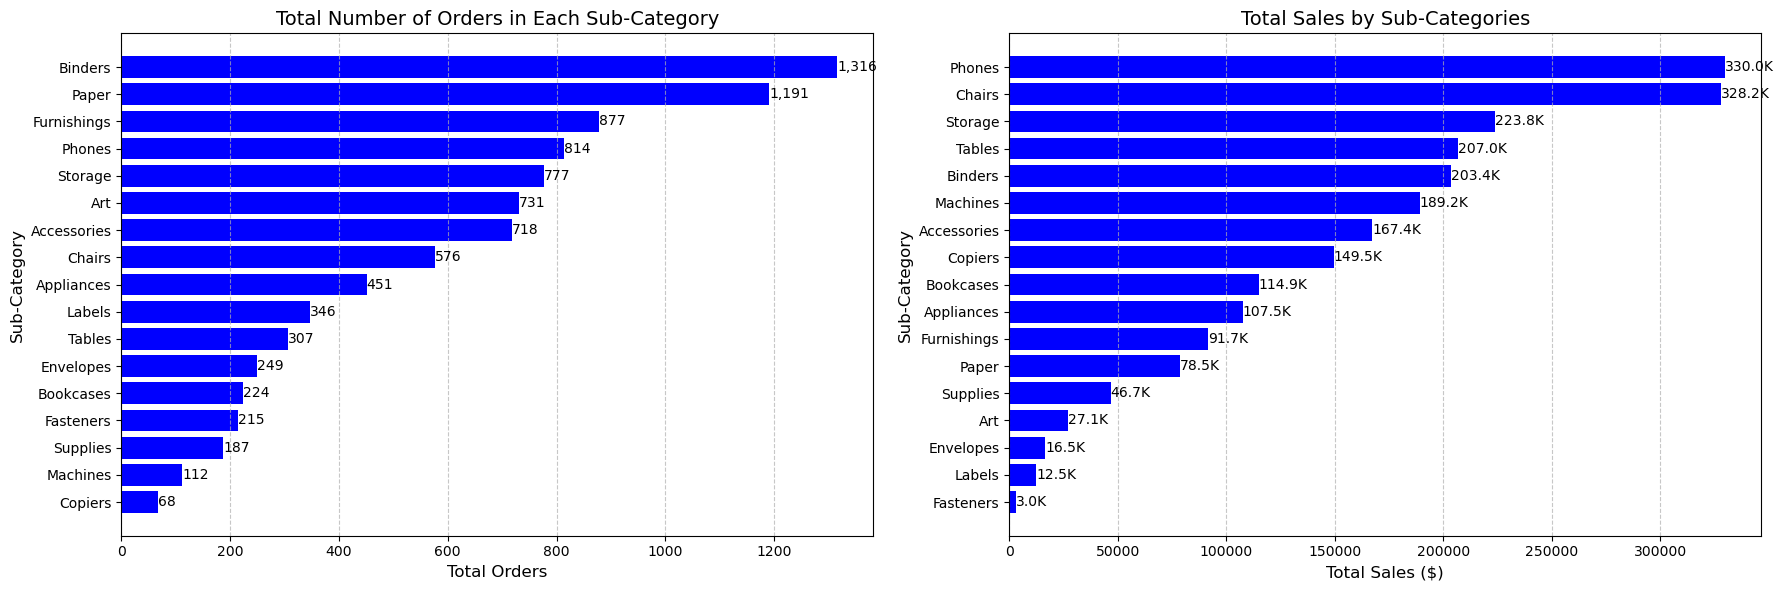

In [64]:
# Compute total number of orders for each sub-category
sub_category_orders = (
    order_details_df_cleaned
    .merge(products_df, on="Product ID", how="left")
    .groupby("Sub-Category")["Order ID"]
    .nunique()
    .reset_index()
    .sort_values(by="Order ID", ascending=False)
    .rename(columns={"Order ID": "Total Orders"})
)

# Compute total sales for each sub-category
top_sub_categories = (
    order_details_df_cleaned
    .merge(products_df, on="Product ID", how="left")
    .groupby("Sub-Category")["Sales"]
    .sum()
    .reset_index()
    .sort_values(by="Sales", ascending=False)
)

# Create side-by-side bar charts for sub-categories
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot total number of orders for each sub-category
bars1 = axes[0].barh(sub_category_orders["Sub-Category"], sub_category_orders["Total Orders"], color="blue")
axes[0].set_xlabel("Total Orders", fontsize=12)
axes[0].set_ylabel("Sub-Category", fontsize=12)
axes[0].set_title("Total Number of Orders in Each Sub-Category", fontsize=14)
axes[0].invert_yaxis()  # Invert y-axis to show highest value at the top
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Add labels on bars for total orders
for bar in bars1:
    axes[0].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():,}', 
                 ha='left', va='center', fontsize=10, color='black')

# Plot total sales for each sub-category
bars2 = axes[1].barh(top_sub_categories["Sub-Category"], top_sub_categories["Sales"], color="blue")
axes[1].set_xlabel("Total Sales ($)", fontsize=12)
axes[1].set_ylabel("Sub-Category", fontsize=12)
axes[1].set_title("Total Sales by Sub-Categories", fontsize=14)
axes[1].invert_yaxis()  # Invert y-axis to show highest value at the top
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# Add labels on bars for total sales in thousands
for bar in bars2:
    axes[1].text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()/1_000:.1f}K', 
                 ha='left', va='center', fontsize=10, color='black')

# Adjust layout
plt.tight_layout()
plt.show()


G- Orders trend per month, quarter and year

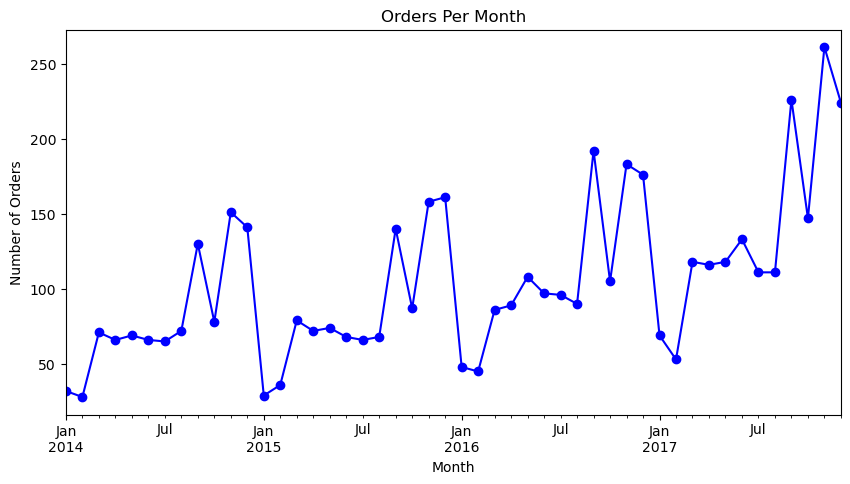

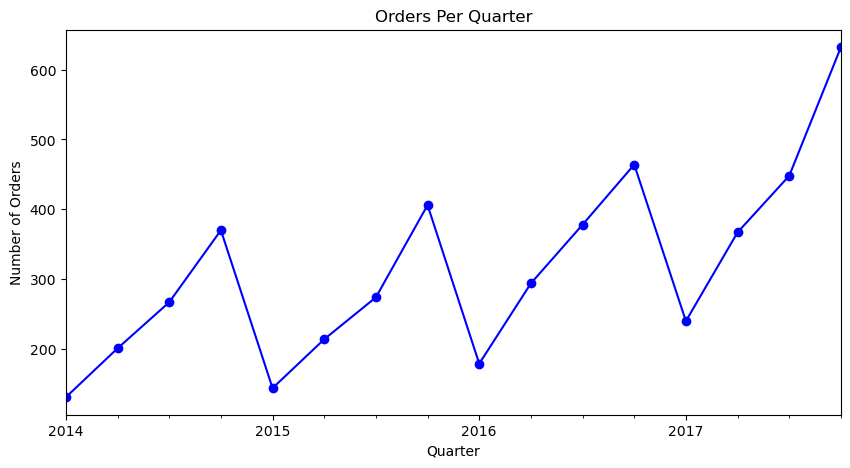

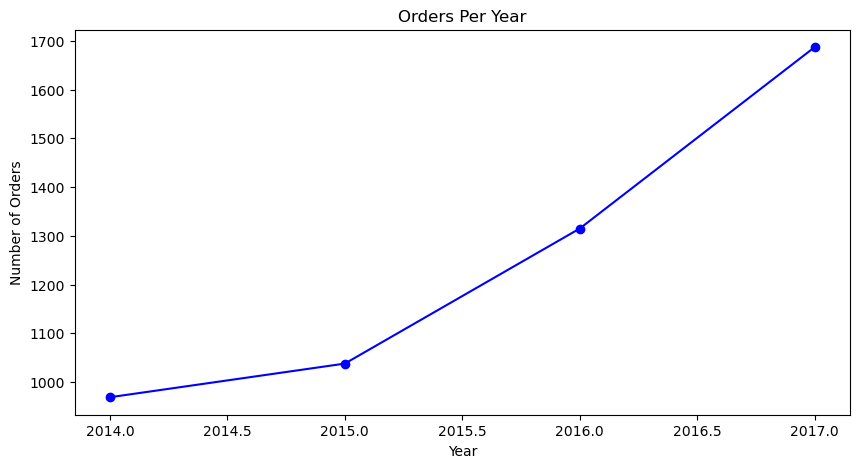

In [65]:
# Extract year, month, and quarter from the corrected "Order Date"
orders_df_cleaned['Order Year'] = orders_df_cleaned['Order Date'].dt.year
orders_df_cleaned['Order Month'] = orders_df_cleaned['Order Date'].dt.to_period('M')  # Year-Month format
orders_df_cleaned['Order Quarter'] = orders_df_cleaned['Order Date'].dt.to_period('Q')  # Year-Quarter format

# Plot order count per month
plt.figure(figsize=(10, 5))
orders_df_cleaned['Order Month'].value_counts().sort_index().plot(kind='line', marker='o', color='b', linestyle='-')
plt.title("Orders Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()

# Plot order count per quarter
plt.figure(figsize=(10, 5))
orders_df_cleaned['Order Quarter'].value_counts().sort_index().plot(kind='line', marker='o', color='b', linestyle='-')
plt.title("Orders Per Quarter")
plt.xlabel("Quarter")
plt.ylabel("Number of Orders")
plt.show()


# Plot order count per year
plt.figure(figsize=(10, 5))
orders_df_cleaned['Order Year'].value_counts().sort_index().plot(kind='line', marker='o', color='b', linestyle='-')
plt.title("Orders Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Orders")
plt.show()

H- Sales trends per month, quarter and year

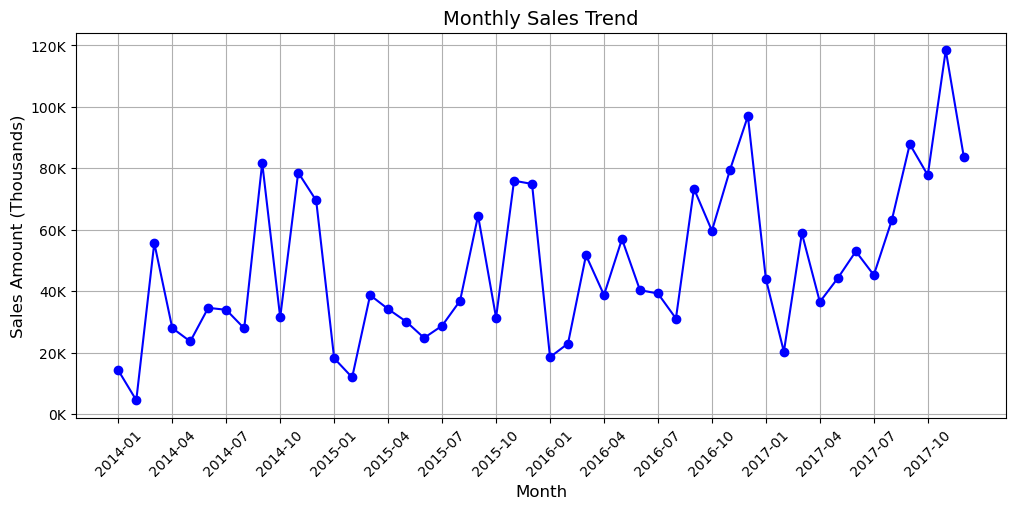

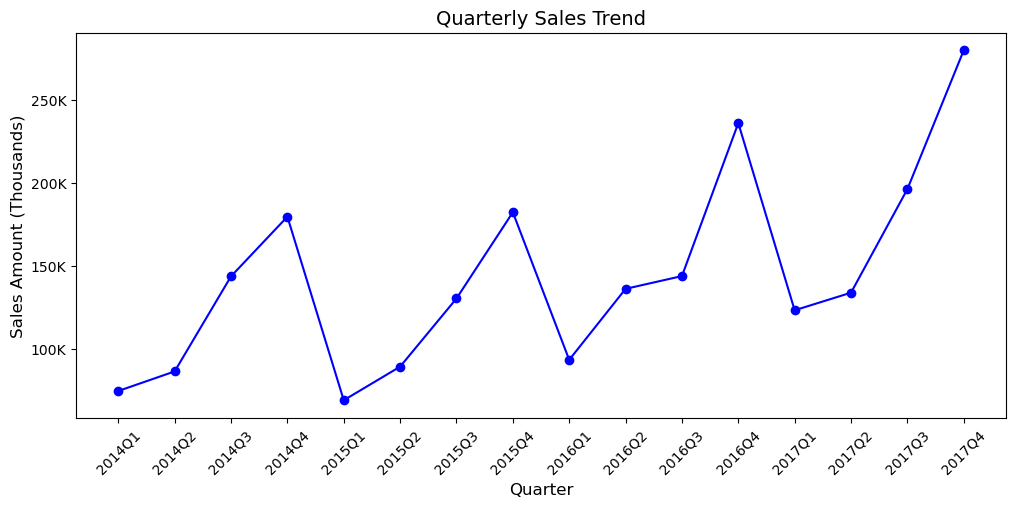

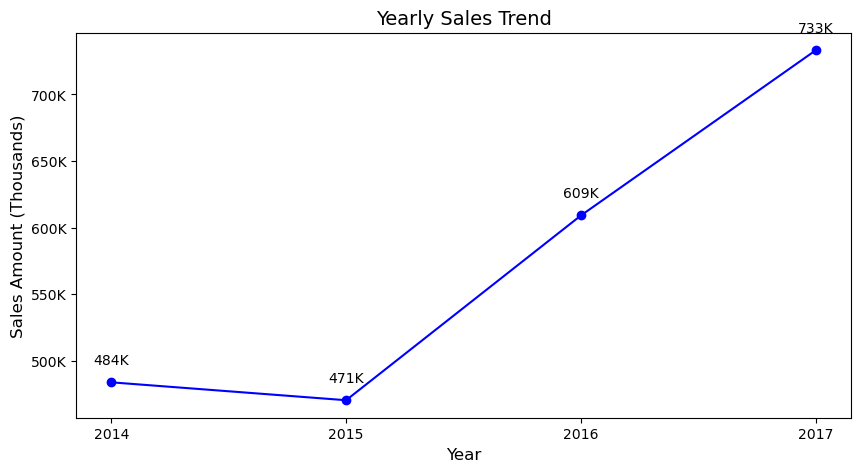

In [66]:
# Convert Order Date to datetime format
orders_df["Order Date"] = pd.to_datetime(orders_df["Order Date"])

# Merge sales data with orders data
sales_data = orders_df.merge(order_details_df_cleaned, on="Order ID", how="left")

# Extract time components
sales_data["Year"] = sales_data["Order Date"].dt.year
sales_data["Quarter"] = sales_data["Order Date"].dt.to_period("Q")
sales_data["Month"] = sales_data["Order Date"].dt.to_period("M")

# Aggregate sales over time
monthly_sales = sales_data.groupby("Month")["Sales"].sum().reset_index()
quarterly_sales = sales_data.groupby("Quarter")["Sales"].sum().reset_index()
yearly_sales = sales_data.groupby("Year")["Sales"].sum().reset_index()


# Plot Monthly Sales
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales["Month"].astype(str), monthly_sales["Sales"], marker="o", linestyle="-", color='blue')
plt.xticks(monthly_sales["Month"].astype(str)[::3], rotation=45)  # Show every 3rd month for better readability
plt.title("Monthly Sales Trend", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Sales Amount (Thousands)", fontsize=12)
plt.grid(True)

# Format y-axis labels in thousands
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:,.0f}K"))

plt.show()

# Plot Quarterly Sales
plt.figure(figsize=(12, 5))
plt.plot(quarterly_sales["Quarter"].astype(str), quarterly_sales["Sales"], marker="o", linestyle="-", color='blue')
plt.xticks(rotation=45)
plt.title("Quarterly Sales Trend", fontsize=14)
plt.xlabel("Quarter", fontsize=12)
plt.ylabel("Sales Amount (Thousands)", fontsize=12)

# Format y-axis labels in thousands
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:,.0f}K"))

plt.show()

# Plot Yearly Sales with better label positioning
plt.figure(figsize=(10, 5))
plt.plot(yearly_sales["Year"].astype(str), yearly_sales["Sales"], marker="o", linestyle="-", color='blue')

# Format y-axis labels in thousands
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1000:,.0f}K"))

# Add labels slightly above the points
for i, txt in enumerate(yearly_sales["Sales"]):
    plt.text(yearly_sales["Year"].astype(str)[i], yearly_sales["Sales"][i] + (total_sales * 0.005), f"{txt/1000:,.0f}K", 
             ha="center", va="bottom", fontsize=10, color='black')

plt.title("Yearly Sales Trend", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Sales Amount (Thousands)", fontsize=12)

plt.show()


# 3. Customer Analysis

A- Customer Segments Contribution to Sales

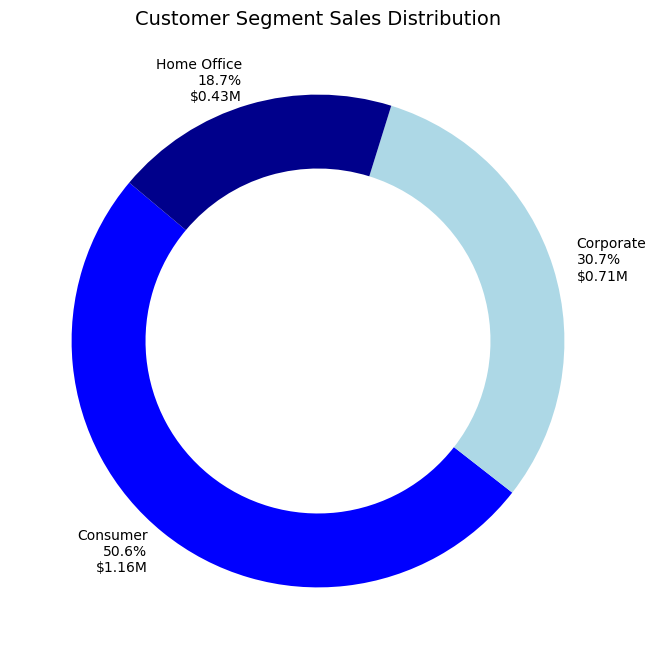

In [67]:
# Compute sales by customer segment
customer_sales = customers_df.merge(orders_df, on="Customer ID").merge(order_details_df_cleaned, on="Order ID")
segment_sales = customer_sales.groupby("Segment")["Sales"].sum().reset_index().sort_values(by="Sales", ascending=False)

# Convert sales to millions
segment_sales["Sales_M"] = segment_sales["Sales"] / 1_000_000

# Calculate percentage contribution
segment_sales["Percentage"] = (segment_sales["Sales"] / segment_sales["Sales"].sum()) * 100

# Create labels with percentage and total sales in millions
labels = [f"{row['Segment']}\n{row['Percentage']:.1f}%\n${row['Sales_M']:.2f}M" for _, row in segment_sales.iterrows()]

# Create donut chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    segment_sales["Sales"], labels=labels, autopct="", startangle=140, colors=['blue', 'lightblue', 'darkblue'], 
    wedgeprops=dict(width=0.3)  # Donut effect
)

# Title
ax.set_title("Customer Segment Sales Distribution", fontsize=14)

plt.show()


B- Percentage of revenue from repeat customers

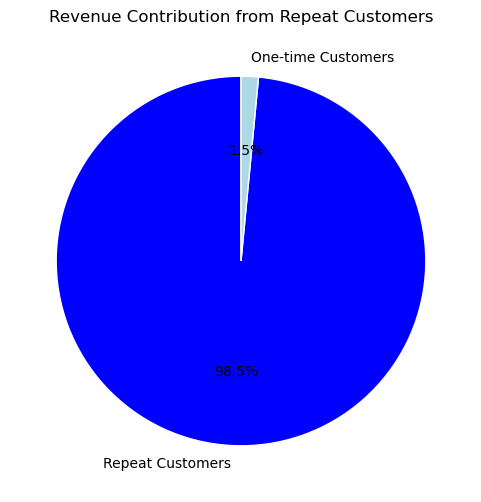

In [68]:
# c- Percentage of revenue from repeat customers
customer_order_counts = customer_sales.groupby("Customer ID")["Order ID"].nunique()
repeat_customers = customer_order_counts[customer_order_counts > 1].count()
total_customers = customer_order_counts.count()
repeat_customer_percentage = (repeat_customers / total_customers) * 100


# Visualizing Repeat Customer Contribution
fig, ax = plt.subplots(figsize=(6, 6))
labels = ["Repeat Customers", "One-time Customers"]
sizes = [repeat_customer_percentage, 100 - repeat_customer_percentage]
colors = ['blue', 'lightblue']
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={"edgecolor": "white"})

ax.set_title("Revenue Contribution from Repeat Customers")
plt.show()

# 4. Shipping & Order Management

A- Average shipping time across regions

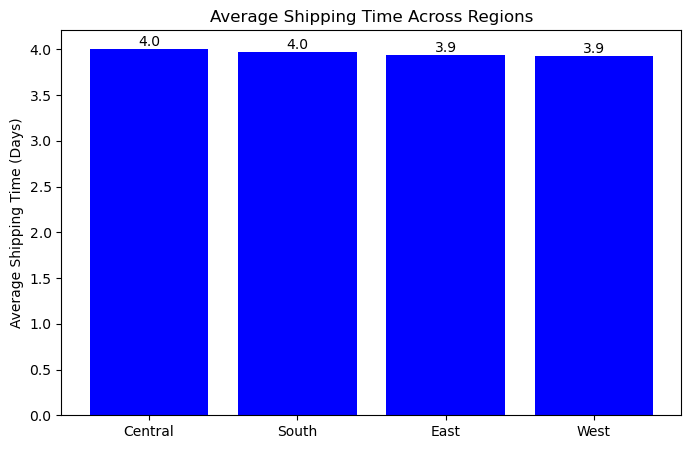

In [69]:
orders_df_cleaned["Shipping Time"] = (pd.to_datetime(orders_df_cleaned["Ship Date"]) - pd.to_datetime(orders_df_cleaned["Order Date"])).dt.days
avg_shipping_time = orders_df_cleaned.groupby("Region")["Shipping Time"].mean().reset_index().sort_values(by="Shipping Time", ascending=False)

# Visualizing Average Shipping Time Across Regions
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(avg_shipping_time["Region"], avg_shipping_time["Shipping Time"], color='blue')
ax.set_ylabel("Average Shipping Time (Days)")
ax.set_title("Average Shipping Time Across Regions")

# Adding labels on bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=10, color='black')

plt.show()

In [70]:
# Convert date columns to datetime format
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

# Calculate delivery time in days
df["Delivery Time"] = (df["Ship Date"] - df["Order Date"]).dt.days

# Get the minimum and maximum delivery time for each shipping mode
delivery_time_stats = df.groupby("Ship Mode")["Delivery Time"].agg(["min", "max"])

# Display the results
delivery_time_stats

,min,max
Ship Mode,,
First Class,1,4
Same Day,0,1
Second Class,1,5
Standard Class,3,7


B- Impact of shipping mode on sales

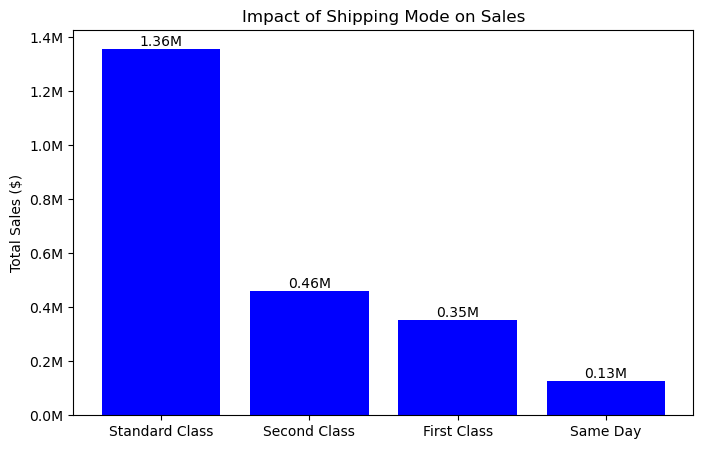

In [71]:
# b- Impact of shipping mode on sales
shipping_mode_sales = orders_df.merge(order_details_df_cleaned, on="Order ID").groupby("Ship Mode")["Sales"].sum().reset_index().sort_values(by="Sales", ascending=False)

# Visualizing Sales by Shipping Mode
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(shipping_mode_sales["Ship Mode"], shipping_mode_sales["Sales"], color='blue')
ax.set_ylabel("Total Sales ($)")
ax.set_title("Impact of Shipping Mode on Sales")

# Adding labels on bars in millions
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()/1_000_000:.2f}M', 
            ha='center', va='bottom', fontsize=10, color='black')

# Formatting y-axis labels in millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/1_000_000:.1f}M"))

plt.show()

C- Delayed_orders: delivery time more than 4 days and count them and display the most delayed order

In [72]:
# Identifying orders with a shipping time greater than 4 days
delayed_orders = orders_df_cleaned[orders_df_cleaned["Shipping Time"] > 4]

# Displaying the delayed orders
delayed_orders

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country,City,State,Region,Order Year,Order Month,Order Quarter,Shipping Time
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,South,2015,2015-10,2015Q4,7
5,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,United States,Los Angeles,California,West,2014,2014-06,2014Q2,5
12,CA-2017-114412,2017-04-15,2017-04-20,Standard Class,AA-10480,United States,Concord,North Carolina,South,2017,2017-04,2017Q2,5
13,CA-2016-161389,2016-12-05,2016-12-10,Standard Class,IM-15070,United States,Seattle,Washington,West,2016,2016-12,2016Q4,5
16,CA-2014-105893,2014-11-11,2014-11-18,Standard Class,PK-19075,United States,Madison,Wisconsin,Central,2014,2014-11,2014Q4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,CA-2016-130225,2016-09-11,2016-09-17,Standard Class,RC-19960,United States,Houston,Texas,Central,2016,2016-09,2016Q3,6
9982,US-2016-157728,2016-09-22,2016-09-28,Standard Class,RC-19960,United States,Grand Rapids,Michigan,Central,2016,2016-09,2016Q3,6
9984,CA-2015-100251,2015-05-17,2015-05-23,Standard Class,DV-13465,United States,Long Beach,New York,East,2015,2015-05,2015Q2,6
9990,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,United States,Costa Mesa,California,West,2017,2017-02,2017Q1,5


In [73]:
# Finding the maximum shipping time
max_shipping_time = orders_df_cleaned["Shipping Time"].max()

max_shipping_time

7

In [74]:
# Finding the order with the most maximum shipping time
most_max_shipping_order = orders_df_cleaned[orders_df_cleaned["Shipping Time"] == orders_df_cleaned["Shipping Time"].max()].iloc[0:1]

# Displaying the record
most_max_shipping_order

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Country,City,State,Region,Order Year,Order Month,Order Quarter,Shipping Time
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,United States,Fort Lauderdale,Florida,South,2015,2015-10,2015Q4,7


# 5. Geographical Sales Analysis

 A- Least and top 10 States in Sales

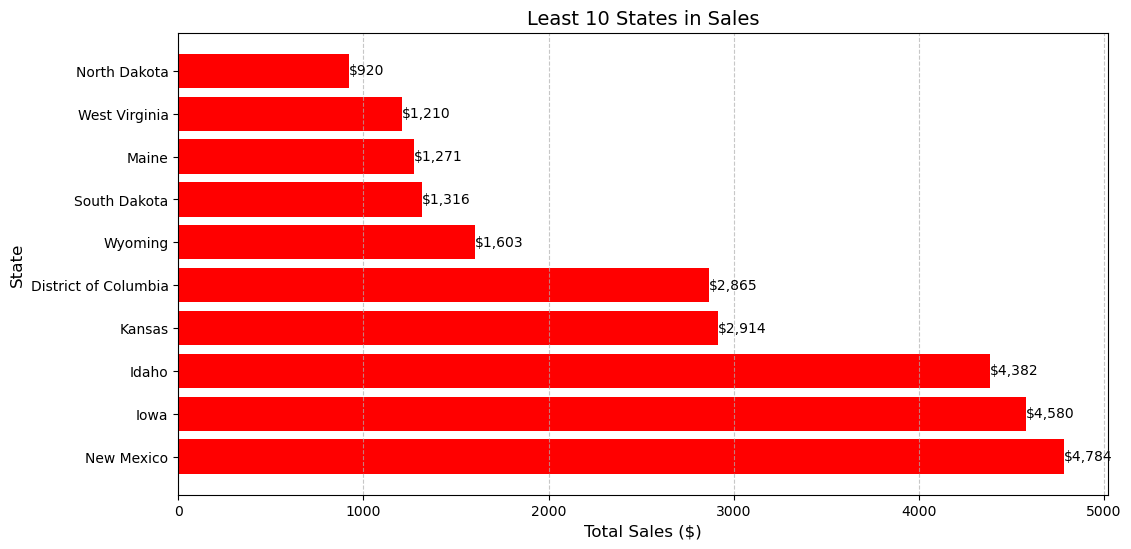

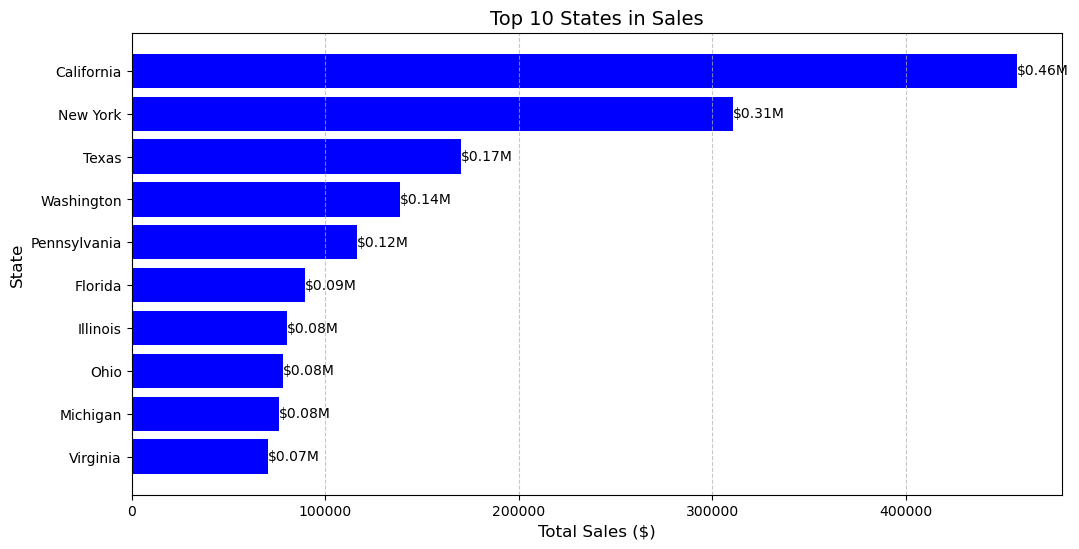

In [75]:
# Compute total sales by state
state_sales = (
    orders_df
    .merge(order_details_df_cleaned, on="Order ID", how="left")
    .groupby("State")["Sales"]
    .sum()
    .reset_index()
    .sort_values(by="Sales", ascending=True)  # Sort in ascending order
)

# Get the least 10 and top 10 states in sales
least_10_states = state_sales.head(10)
top_10_states = state_sales.tail(10).sort_values(by="Sales", ascending=False)

# Plot Least 10 States in Sales
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(least_10_states["State"], least_10_states["Sales"], color="red")

# Add labels on bars in normal numbers
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'${bar.get_width():,.0f}', 
            ha='left', va='center', fontsize=10, color='black')

# Formatting and labels
ax.set_xlabel("Total Sales ($)", fontsize=12)
ax.set_ylabel("State", fontsize=12)
ax.set_title("Least 10 States in Sales", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the lowest-selling state at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

# Plot Top 10 States in Sales
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_10_states["State"], top_10_states["Sales"], color="blue")

# Add labels on bars in millions
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'${bar.get_width()/1_000_000:.2f}M', 
            ha='left', va='center', fontsize=10, color='black')

# Formatting and labels
ax.set_xlabel("Total Sales ($)", fontsize=12)
ax.set_ylabel("State", fontsize=12)
ax.set_title("Top 10 States in Sales", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the highest-selling state at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


B- Total Sales and Number of Orders by Region

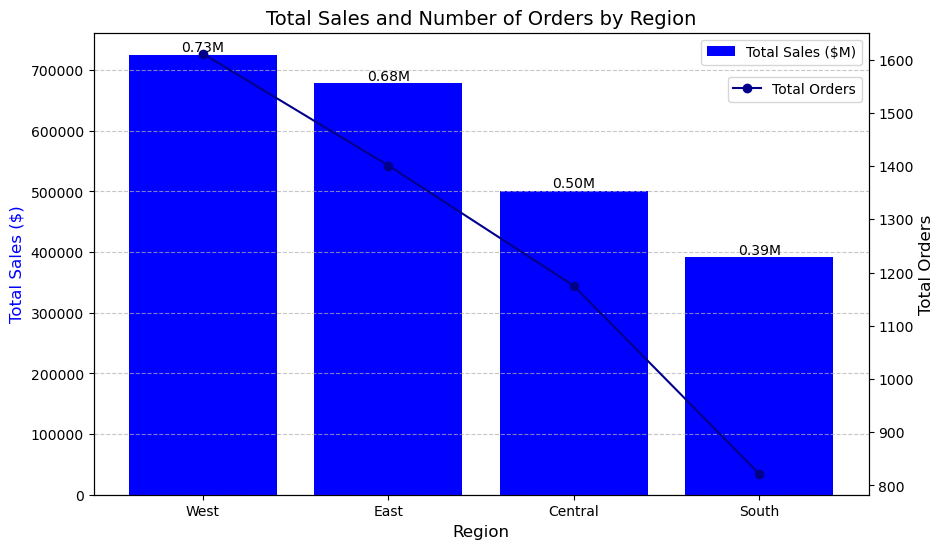

In [76]:
# Compute total sales and total orders for each region
region_sales_orders = (
    orders_df
    .merge(order_details_df_cleaned, on="Order ID", how="left")
    .groupby("Region")
    .agg({"Sales": "sum", "Order ID": "nunique"})
    .reset_index()
    .rename(columns={"Order ID": "Total Orders"})
    .sort_values(by="Sales", ascending=False)
)

# Create a dual-axis bar chart for total sales and total orders by region
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for total sales
bars = ax1.bar(region_sales_orders["Region"], region_sales_orders["Sales"], color="blue", label="Total Sales ($M)")

# Add labels on bars for sales in millions
for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height()/1_000_000:.2f}M', 
             ha='center', va='bottom', fontsize=10, color='black')

# Line chart for total orders
ax2 = ax1.twinx()
ax2.plot(region_sales_orders["Region"], region_sales_orders["Total Orders"], marker="o", linestyle="-", color="darkblue")


# Formatting and labels
ax1.set_xlabel("Region", fontsize=12)
ax1.set_ylabel("Total Sales ($)", fontsize=12, color="blue")
ax2.set_ylabel("Total Orders", fontsize=12, color="black")
ax1.set_title("Total Sales and Number of Orders by Region", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Move legends to the upper right
ax1.legend(["Total Sales ($M)"], loc="upper right")
ax2.legend(["Total Orders"], loc="upper right", bbox_to_anchor=(1, 0.92))

plt.show()


C- Average Order Value by Region

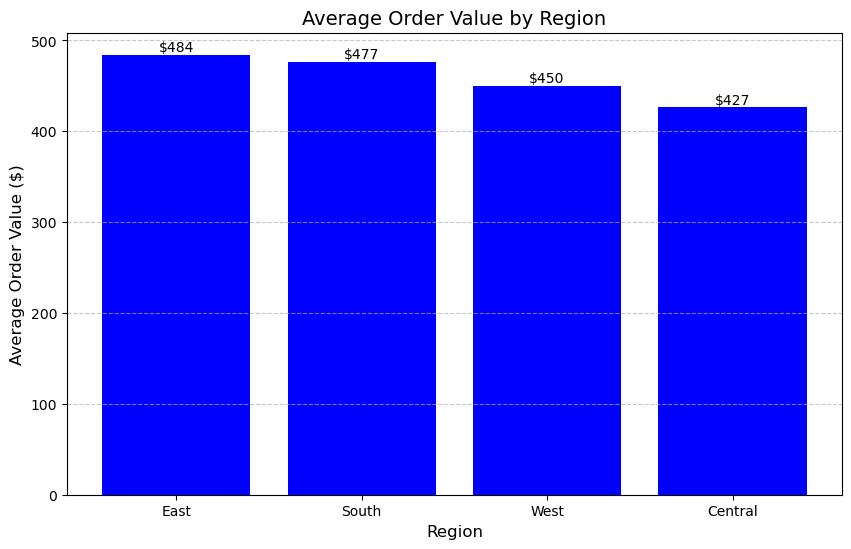

In [77]:
# Compute Average Order Value (AOV) by Region
region_aov = (
    orders_df
    .merge(order_details_df_cleaned, on="Order ID", how="left")
    .groupby("Region")
    .agg({"Sales": "sum", "Order ID": "nunique"})
    .reset_index()
)

region_aov["Average Order Value"] = region_aov["Sales"] / region_aov["Order ID"]
region_aov = region_aov.sort_values(by="Average Order Value", ascending=False)

# Plot Average Order Value by Region
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(region_aov["Region"], region_aov["Average Order Value"], color="blue")

# Add labels on bars in dollars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'${bar.get_height():,.0f}', 
            ha='center', va='bottom', fontsize=10, color='black')

# Formatting and labels
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Average Order Value ($)", fontsize=12)
ax.set_title("Average Order Value by Region", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# Prediction

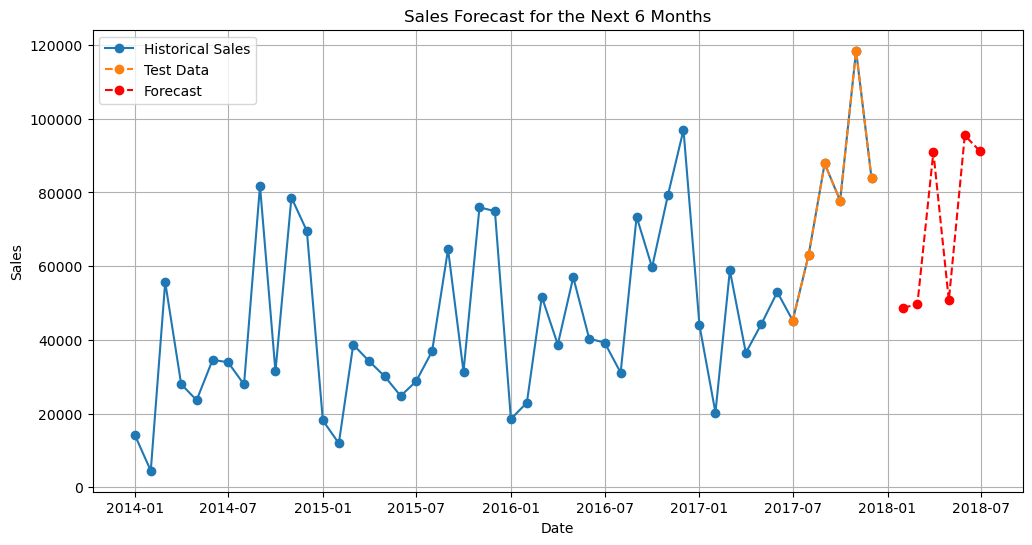

In [78]:

# Convert Order Date to datetime for time-series analysis
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'])

# Aggregate sales over time (monthly)
orders_df['YearMonth'] = orders_df['Order Date'].dt.to_period('M')
monthly_sales = order_details_df.merge(orders_df, on="Order ID") \
    .groupby("YearMonth")['Sales'].sum().reset_index()

# Convert period to datetime for modeling
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['YearMonth'])

# Train-test split (last 6 months as test)
train_data = monthly_sales[:-6]
test_data = monthly_sales[-6:]

# Apply Holt-Winters Exponential Smoothing for forecasting
model = ExponentialSmoothing(train_data['Sales'], trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()

# Forecast next 6 months
future_months = pd.date_range(start=monthly_sales['YearMonth'].max(), periods=7, freq='M')[1:]
forecast = fit.forecast(steps=6)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Sales'], label="Historical Sales", marker='o')
plt.plot(test_data['YearMonth'], test_data['Sales'], label="Test Data", marker='o', linestyle="dashed")
plt.plot(future_months, forecast, label="Forecast", marker='o', linestyle="dashed", color='red')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Forecast for the Next 6 Months")
plt.legend()
plt.grid(True)
plt.show()

# Display predicted values
forecast_df = pd.DataFrame({"YearMonth": future_months, "Predicted Sales": forecast})

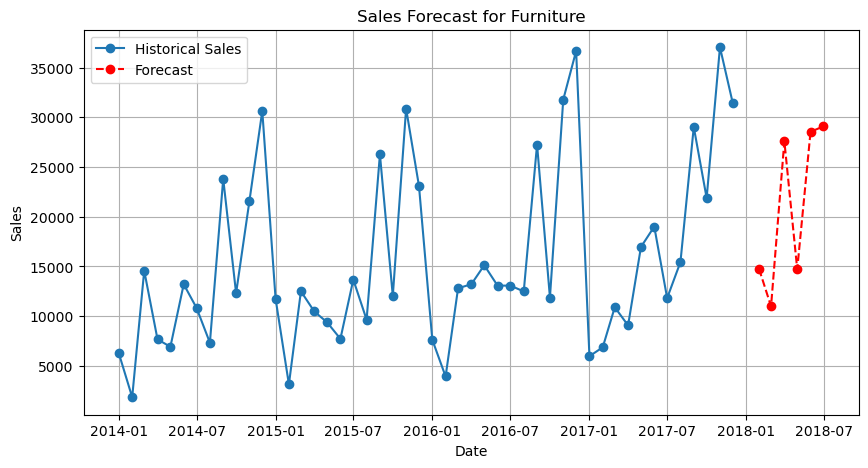

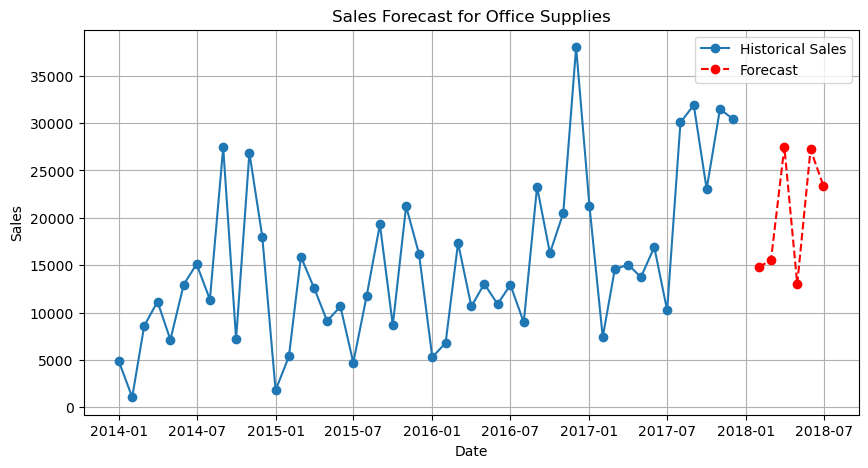

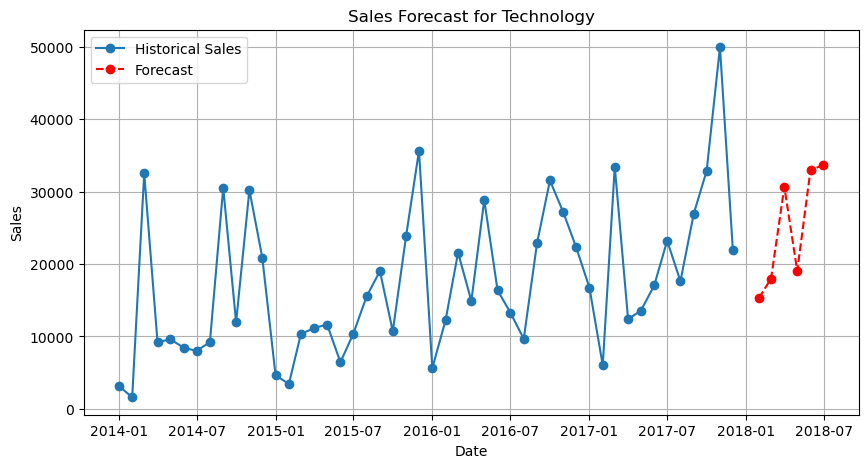

In [79]:
# Forecasting Sales by Category with Separate Graphs

# Merge order details with products to get category-wise sales
category_sales = order_details_df.merge(products_df, on="Product ID") \
    .merge(orders_df, on="Order ID")

# Aggregate sales by category over time
category_sales['YearMonth'] = category_sales['Order Date'].dt.to_period('M')
category_trends = category_sales.groupby(['YearMonth', 'Category'])['Sales'].sum().reset_index()

# Convert period to datetime for modeling
category_trends['YearMonth'] = category_trends['YearMonth'].astype(str)
category_trends['YearMonth'] = pd.to_datetime(category_trends['YearMonth'])

# Create separate plots for each category
for category in category_trends['Category'].unique():
    plt.figure(figsize=(10, 5))
    
    cat_data = category_trends[category_trends['Category'] == category]
    
    # Train-test split (last 6 months as test)
    train_data = cat_data[:-6]
    
    # Apply Holt-Winters Exponential Smoothing for forecasting
    model = ExponentialSmoothing(train_data['Sales'], trend="add", seasonal="add", seasonal_periods=12)
    fit = model.fit()
    
    # Forecast next 6 months
    forecast = fit.forecast(steps=6)
    
    # Plot historical sales
    plt.plot(cat_data['YearMonth'], cat_data['Sales'], label="Historical Sales", marker='o', linestyle="-")
    
    # Plot forecast
    plt.plot(future_months, forecast, label="Forecast", marker='o', linestyle="dashed", color='red')

    # Formatting
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Sales Forecast for {category}")
    plt.legend()
    plt.grid(True)
    plt.show()